In [1]:
%matplotlib inline

import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import truncnorm

# Signal-in-white-noise model: adaptive method using a surrogate marginal likelihood (Jordan '16)

## Distributed dataset

In [6]:
N = 300 # number of observed coefficients
tau = 1 # scale of the prior
n = 4800 # size of the dataset
m = 40 # number of machines
beta = 1 # smoothness of the parameters
sigma = 1
alpha = 1 # smoothness of the prior

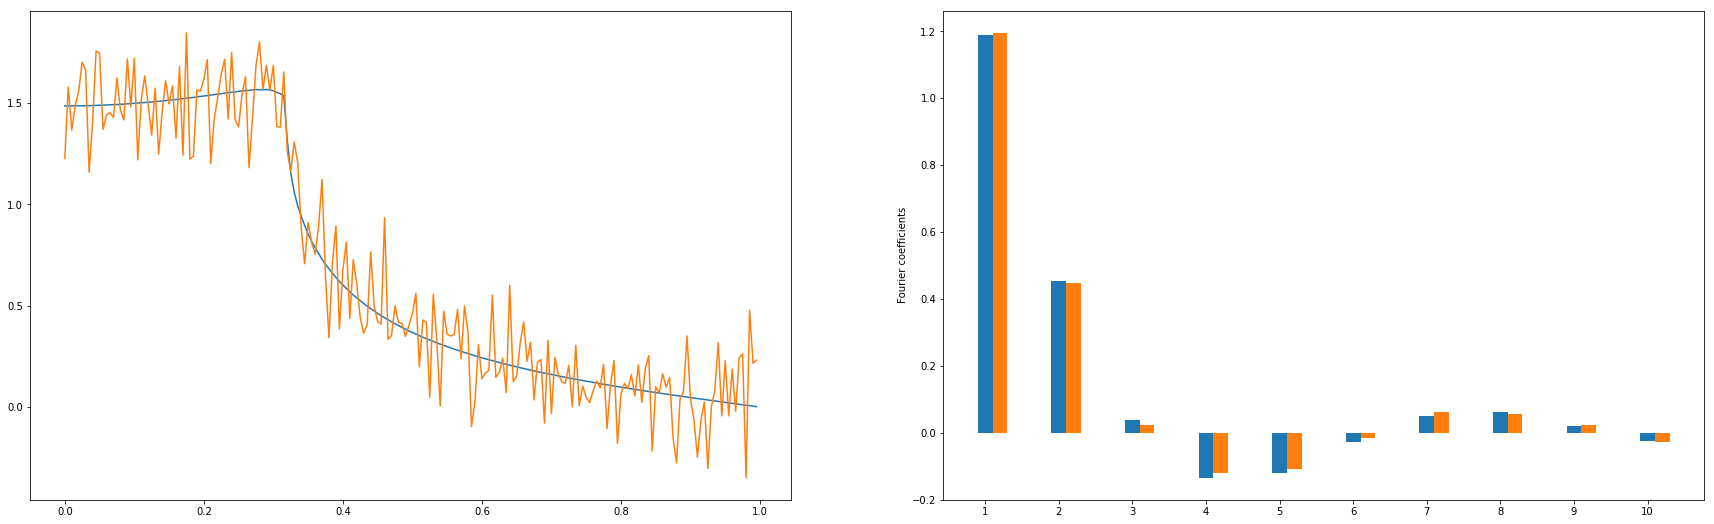

In [9]:
theta = np.sin(np.arange(1.0,N+1.0,1.0)) * np.sqrt(2) / (np.arange(1.0,N+1.0,1.0)) ** 1.5
data = np.tile(theta, (m,1)) + np.sqrt(sigma * m / n) * np.random.normal(size=(m,N))

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.005)
Y = [np.sum(theta * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_n = [np.sum(np.mean(data,axis=0) * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_n)

a = ax[1]
index = np.arange(1,11,1)
bar_width = 0.2
opacity = 1
a.bar(index, theta[:10], bar_width, align='center', alpha=opacity)
a.bar(index + bar_width, np.mean(data,axis=0)[:10], bar_width, align='center', alpha=opacity)
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')

## Estimation of $\alpha$

We want to find:
$$ \hat{\alpha} = \arg \max_{\alpha} \log \int_{\theta} \Pi_{j = 1}^{m} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$

Let's call 
$$\mathcal{L}_m(\alpha) =  \log \int_{\theta} \Pi_{j = 1}^{m} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$ the log global marginal likelihood function and
$$\mathcal{L}_j(\alpha) =  \log \int_{\theta} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$
the local one on node $j$

Inspired by Jordan et al.'s work, we can write a surrogate marginal likelihood function as follows:
$$ \tilde{\mathcal{L}}(\alpha) = \mathcal{L}_1(\alpha) - \alpha \times (\mathcal{L}_1'(\bar\alpha) - \mathcal{L}_m'(\bar\alpha))$$
where $\bar\alpha$ is an initial estimator, for example $ \bar{\alpha} = \arg \max_{\alpha} \mathcal{L}_1(\alpha)$

In our setting with a Gaussian prior $\theta | \alpha \sim \mathcal N(0,\tau i^{-1-2\alpha}$ and a Gaussian local likelihood  $Y^j_i | \theta_i \sim \mathcal N(\theta_i,\sigma^2m/n)$, the local log marginal likelihood has a closed form:
$$ \mathcal{L}_1(\alpha) = \log \int_{\theta} \Pi_{i=1}^{\infty} p(Y_i^j | \theta_i) \pi(\theta_i | \alpha) d\theta_i $$
$$ \mathcal{L}_1(\alpha) = \log \sum_{i=1}^{\infty} \int_{-\infty}^{+\infty} p(Y_i^j | \theta_i) \pi(\theta_i | \alpha) d\theta_i $$
$$ \mathcal{L}_1(\alpha) = \log \sum_{i=1}^{\infty} \mathcal{L}^i_1(\alpha)$$
and $$ \mathcal{L}^i_1(\alpha) = \frac 1 2 \log(\frac{n i^{1+2\alpha}}{\tau m}) + \log(\frac{Y_i^1 m \sigma} n) -2\log(\sigma^2 m /n + \tau i^{-1-2\alpha}) - \frac{Y_i^1 n}{2m\sigma^2} + \frac{{Y_i^1 n m}^2}{2m^2\sigma^4}\frac 1 {\sigma^2 m /n + \tau i^{-1-2\alpha}} $$

The derivative of the local surrogate marginals also have a closed form and we can approximate the derivative of the global marginal likelihood at the initial point using Deseingrot and Ng (2015) technique:
$$ \mathcal{L}'_m(\bar\alpha) = \sum_{j=1}^{m} \mathcal{L}'_j(\bar\alpha) $$